In [1]:
# SETUP & DATA LOADING

!pip install -q transformers spacy scikit-learn tensorflow nltk wordcloud matplotlib seaborn
!python -m spacy download en_core_web_sm
!pip install textblob


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from textblob import TextBlob


# Load data
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df = df.iloc[:6000].copy()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# PREPROCESSING

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    tokens = [word for word in text.split() if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['clean_review'] = df['Review'].apply(preprocess)
df = df.dropna(subset=['clean_review', 'Rating'])
df = df[df['clean_review'].str.strip() != '']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# OPINION MINING

nlp = spacy.load("en_core_web_sm")

def extract_opinions(text):
    doc = nlp(text)
    opinions = []
    for token in doc:
        if token.pos_ == 'ADJ' and token.head.pos_ == 'NOUN':
            target = token.head.text
            opinion_word = token.text
            polarity = TextBlob(opinion_word).sentiment.polarity
            sentiment = 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
            opinions.append((target, opinion_word, sentiment))
    return opinions

df['opinions'] = df['clean_review'].apply(extract_opinions)


In [4]:
# LABEL ENCODING

def label_sentiment(rating):
    if rating >= 4: return 'positive'
    elif rating == 3: return 'neutral'
    else: return 'negative'

df['sentiment'] = df['Rating'].apply(label_sentiment)
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}
df['label'] = df['sentiment'].map(label2id)


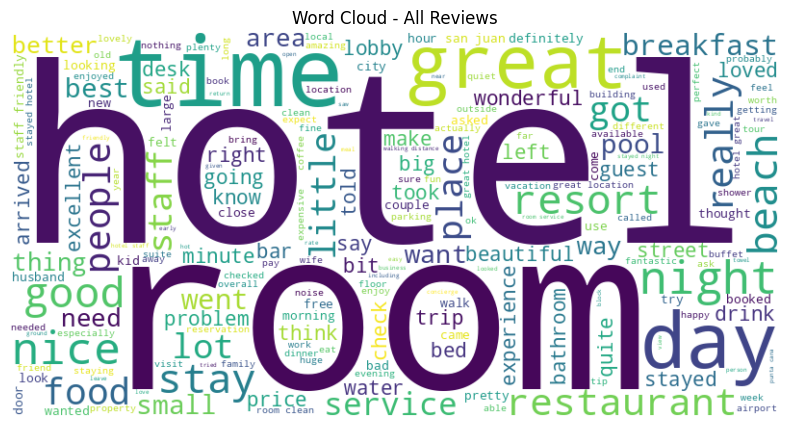

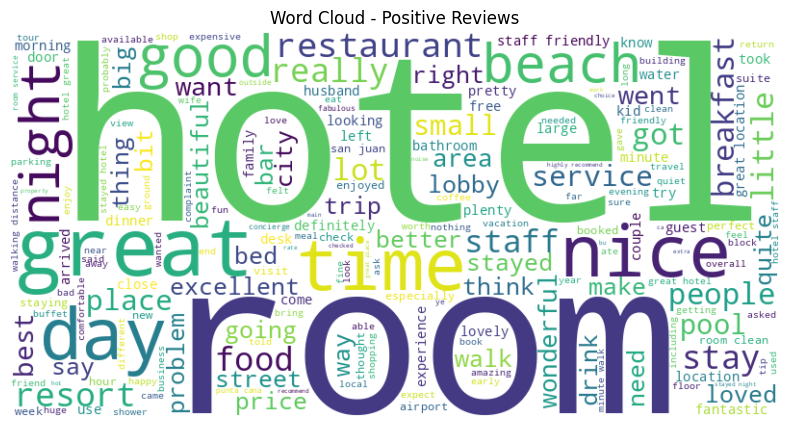

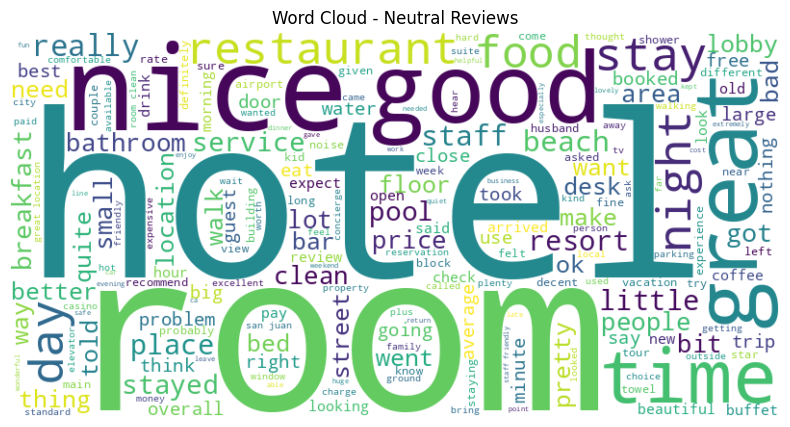

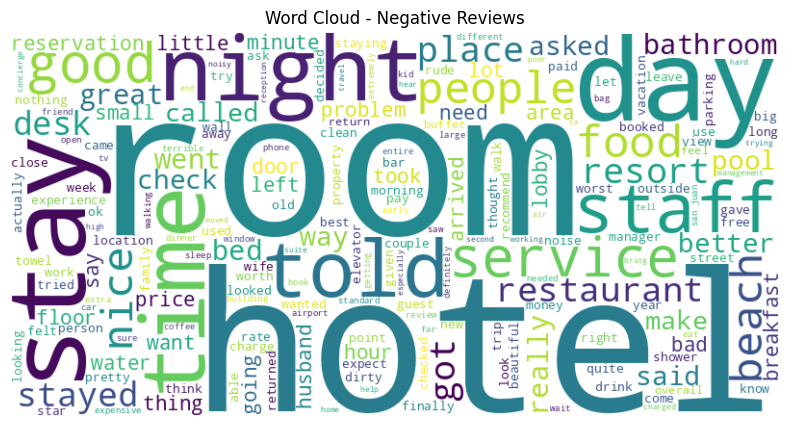

In [5]:
# WordCloud for all reviews
all_text = ' '.join(df['clean_review'])
wordcloud_all = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Reviews')
plt.show()

# WordClouds for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment.capitalize()} Reviews')
    plt.show()

In [6]:
# TRAIN/TEST SPLIT

X = df['clean_review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
# CLASSICAL ML MODELS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_tfidf, y_train)
logreg_pred = logreg.predict(X_test_tfidf)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)

# SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)

In [8]:
# DEEP LEARNING MODELS (BiLSTM & CNN)

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

max_words = 10000
max_len = 128

tokenizer_dl = Tokenizer(num_words=max_words)
tokenizer_dl.fit_on_texts(X_train)

X_train_seq = tokenizer_dl.texts_to_sequences(X_train)
X_test_seq = tokenizer_dl.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# BiLSTM
bilstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
bilstm_model.fit(X_train_pad, y_train_cat, epochs=3, batch_size=64, validation_split=0.1, verbose=1)
bilstm_pred = np.argmax(bilstm_model.predict(X_test_pad), axis=1)  # Now uses imported np

# CNN
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
cnn_model.fit(X_train_pad, y_train_cat, epochs=3, batch_size=64, validation_split=0.1, verbose=1)
cnn_pred = np.argmax(cnn_model.predict(X_test_pad), axis=1)  # Now uses imported np


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6918 - loss: 0.8566 - val_accuracy: 0.7729 - val_loss: 0.5903
Epoch 2/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8306 - loss: 0.4743 - val_accuracy: 0.8146 - val_loss: 0.4875
Epoch 3/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8906 - loss: 0.2874 - val_accuracy: 0.8062 - val_loss: 0.5458
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch 1/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6610 - loss: 0.8876 - val_accuracy: 0.7167 - val_loss: 0.7434
Epoch 2/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7284 - loss: 0.6682 - val_accuracy: 0.7563 - val_loss: 0.5932
Epoch 3/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8304 - loss: 0.4471 - val_accuracy: 0.8146 - val_loss: 0.5399
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [8]:
# DOCUMENT-LEVEL BERT (WITH MODEL SAVING)
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import os

# Create directory to save model
model_save_dir = "./bert_sentiment_model"
os.makedirs(model_save_dir, exist_ok=True)

# Load model and tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Encode data
train_encodings = bert_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train)
test_dataset = SentimentDataset(test_encodings, y_test)

# Training arguments with saving enabled
training_args = TrainingArguments(
    output_dir=model_save_dir,  # Save to our directory
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",  # Save at each epoch
    save_total_limit=2,     # Keep only last 2 checkpoints
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True  # Load best model at end of training
)

# Trainer with model saving
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')
    }
)

# Train and save final model
trainer.train()
trainer.save_model(model_save_dir)  # Ensure final model is saved
bert_tokenizer.save_pretrained(model_save_dir)  # Save tokenizer

# Evaluate
bert_pred = np.argmax(trainer.predict(test_dataset).predictions, axis=1)

# Zip the model directory for download
!zip -r bert_sentiment_model.zip {model_save_dir}

# Download the model
from google.colab import files
files.download('bert_sentiment_model.zip')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.567700,0.427523,0.851667,0.826194
2,0.354700,0.441971,0.856667,0.847925


  adding: bert_sentiment_model/ (stored 0%)
  adding: bert_sentiment_model/tokenizer.json (deflated 71%)
  adding: bert_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: bert_sentiment_model/model.safetensors (deflated 7%)
  adding: bert_sentiment_model/checkpoint-1200/ (stored 0%)
  adding: bert_sentiment_model/checkpoint-1200/trainer_state.json (deflated 82%)
  adding: bert_sentiment_model/checkpoint-1200/optimizer.pt (deflated 20%)
  adding: bert_sentiment_model/checkpoint-1200/scheduler.pt (deflated 56%)
  adding: bert_sentiment_model/checkpoint-1200/model.safetensors (deflated 7%)
  adding: bert_sentiment_model/checkpoint-1200/config.json (deflated 51%)
  adding: bert_sentiment_model/checkpoint-1200/rng_state.pth (deflated 25%)
  adding: bert_sentiment_model/checkpoint-1200/training_args.bin (deflated 52%)
  adding: bert_sentiment_model/checkpoint-600/ (stored 0%)
  adding: bert_sentiment_model/checkpoint-600/trainer_state.json (deflated 81%)
  adding: bert_sentimen

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import zipfile
import os

# Paths
zip_path = '/content/bert_sentiment_model.zip'
extract_dir = '/content/bert_sentiment_model'

# 1. Extract the zip file
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Model extracted to {extract_dir}')

# 2. Load the model and tokenizer
from transformers import BertForSequenceClassification, BertTokenizerFast

model = BertForSequenceClassification.from_pretrained(extract_dir)
tokenizer = BertTokenizerFast.from_pretrained(extract_dir)

print("Model and tokenizer loaded successfully!")

Model extracted to /content/bert_sentiment_model
Model and tokenizer loaded successfully!


In [18]:
# ASPECT-BASED SA

def extract_aspects(text):
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) > 1]

df['aspects'] = df['clean_review'].apply(extract_aspects)

# Optimized ABSA function
def aspect_sentiment(row):
    aspect_sents = {}
    for aspect in row['aspects']:
        # Use aspect + context sentence
        context_sentences = [sent.text for sent in nlp(row['clean_review']).sents if aspect in sent.text]
        if context_sentences:
            # Use first matching sentence
            input_text = f"{aspect} [SEP] {context_sentences[0]}"
            try:
                result = aspect_pipeline(input_text, truncation=True, max_length=128)[0]
                aspect_sents[aspect] = result['label']
            except:
                aspect_sents[aspect] = "error"
    return aspect_sents

# Run on 1000-row sample
df_sample = df.head(1000).copy()
df_sample['aspect_sentiments'] = df_sample.apply(aspect_sentiment, axis=1)

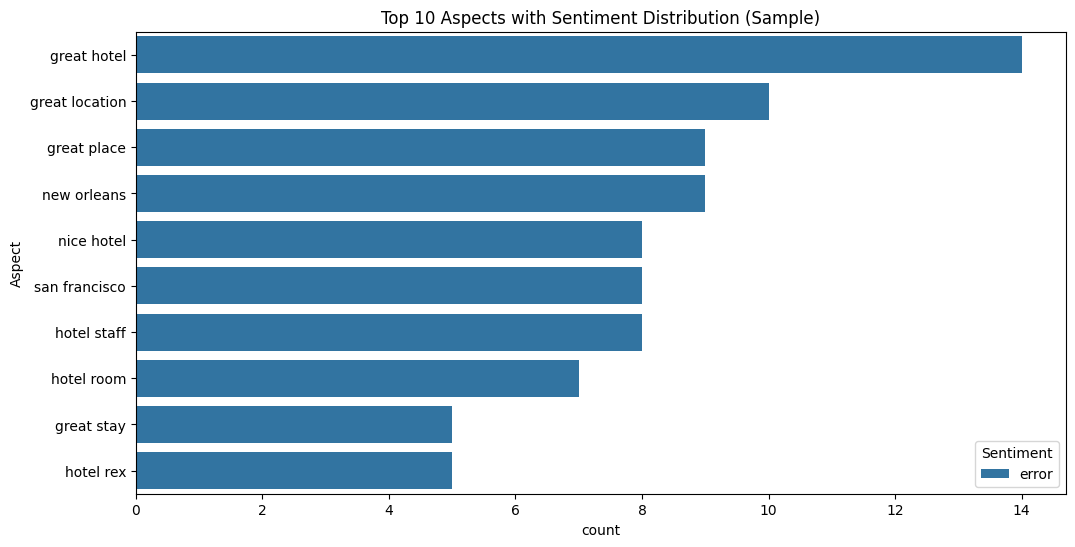

In [19]:
# VISUALIZATION

# Aspect sentiment distribution (using sample)
aspect_data = []
for idx, row in df_sample.iterrows():
    for aspect, sentiment in row['aspect_sentiments'].items():
        aspect_data.append({'Aspect': aspect, 'Sentiment': sentiment})

aspect_df = pd.DataFrame(aspect_data)
plt.figure(figsize=(12,6))
sns.countplot(y='Aspect', hue='Sentiment', data=aspect_df,
              order=aspect_df['Aspect'].value_counts().iloc[:10].index)
plt.title('Top 10 Aspects with Sentiment Distribution (Sample)')
plt.show()



In [24]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from transformers import BertTokenizerFast, BertForSequenceClassification
import gc

# 1. Clear memory
gc.collect()

# 2. Load model and tokenizer on CPU
model = BertForSequenceClassification.from_pretrained(extract_dir)
tokenizer = BertTokenizerFast.from_pretrained(extract_dir)

# 3. Prepare test data
batch_size = 32  # Larger batch size is possible on CPU
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

# Create tensors
input_ids = torch.tensor(test_encodings['input_ids'])
attention_mask = torch.tensor(test_encodings['attention_mask'])
labels = torch.tensor(y_test.tolist())

test_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 4. Generate predictions on CPU
device = torch.device("cpu")  # Force CPU
model.to(device)
model.eval()

bert_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids_batch, attention_mask_batch, labels_batch = batch  # Already on CPU
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).numpy()  # No .cpu() needed
        bert_pred.extend(batch_preds)

bert_pred = np.array(bert_pred)
print("BERT predictions generated successfully on CPU!")


BERT predictions generated successfully on CPU!


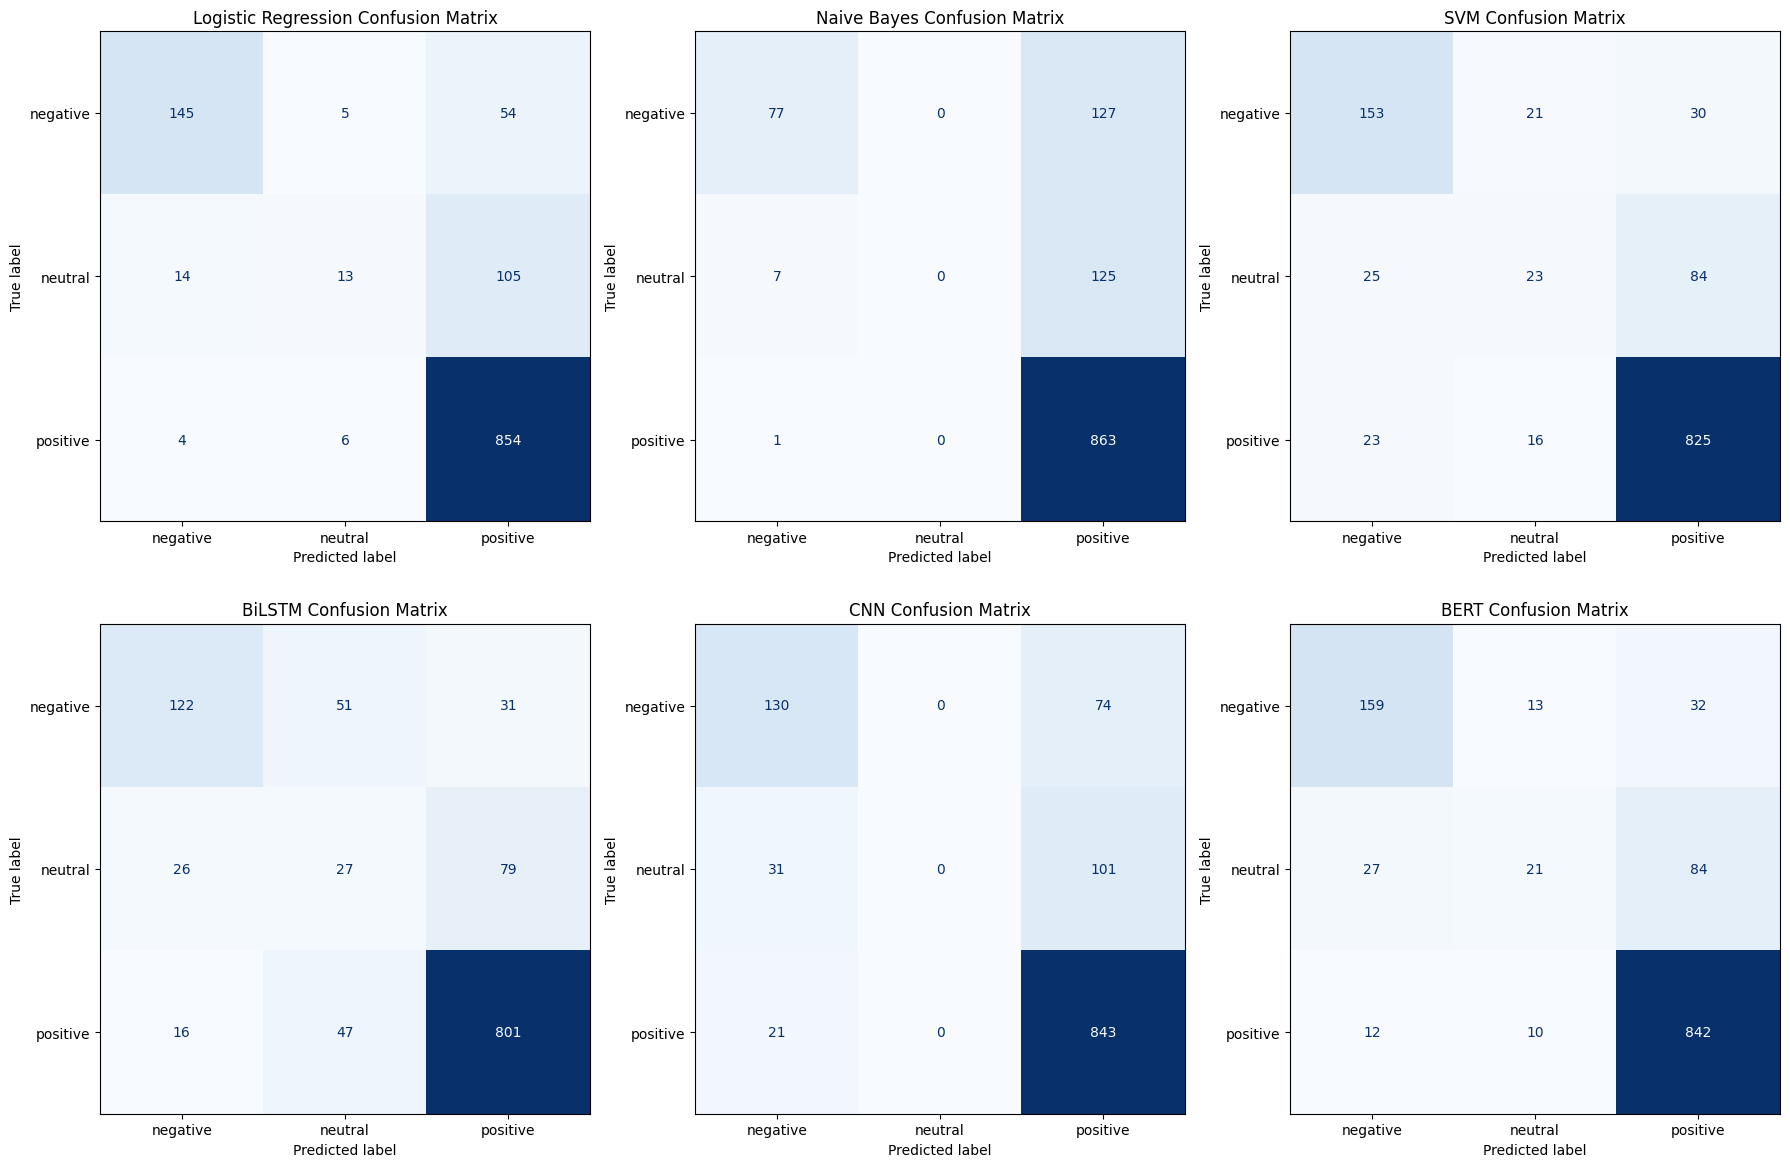

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


model_preds = {
    'Logistic Regression': logreg_pred,
    'Naive Bayes': nb_pred,
    'SVM': svm_pred,
    'BiLSTM': bilstm_pred,
    'CNN': cnn_pred,
    'BERT': bert_pred
}

model_true_labels = {
    'Logistic Regression': y_test,
    'Naive Bayes': y_test,
    'SVM': y_test,
    'BiLSTM': y_test,
    'CNN': y_test,
    'BERT': y_test
}

class_names = ['negative', 'neutral', 'positive']

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model_name, preds) in enumerate(model_preds.items()):
    cm = confusion_matrix(model_true_labels[model_name], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'{model_name} Confusion Matrix')


for j in range(len(model_preds), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [26]:
# COMPARISON TABLE

results = []
for model_name in model_preds:
    y_true = model_true_labels[model_name]
    y_pred = model_preds[model_name]
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred, average='weighted')
    })
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,F1
0,Logistic Regression,0.843333,0.807839
1,Naive Bayes,0.783333,0.718542
2,SVM,0.834167,0.813700
3,BiLSTM,0.791667,0.785656
4,CNN,0.810833,0.759524
5,BERT,0.851667,0.826194


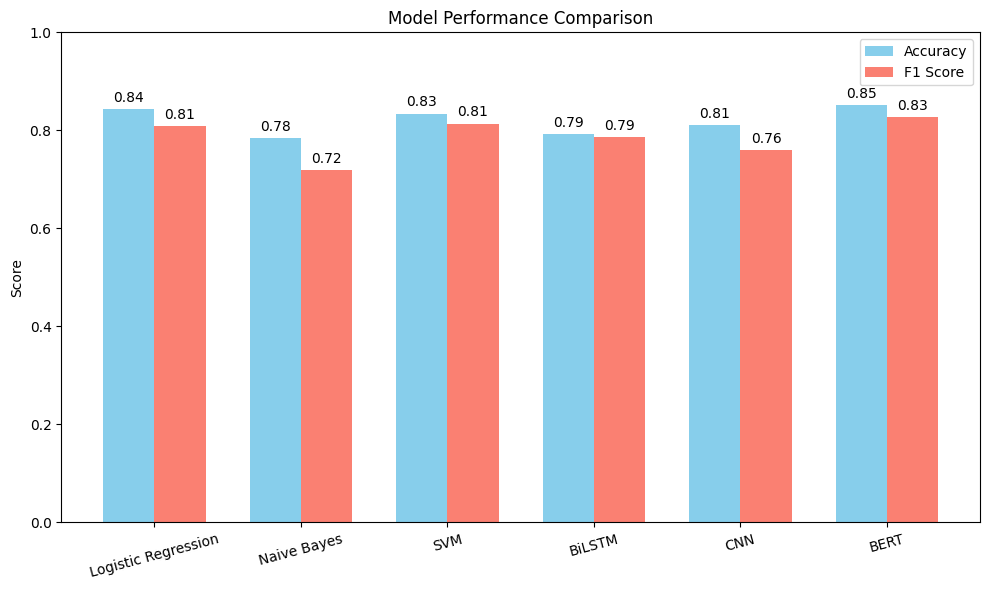

In [27]:
# DOUBLE BAR CHART (F1 & ACCURACY)

import numpy as np

x = np.arange(len(results_df['Model']))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, results_df['F1'], width, label='F1 Score', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=15)
ax.set_ylim(0, 1)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [28]:
# CLASSIFICATION REPORTS

from sklearn.metrics import classification_report
for model_name in model_preds:
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(model_true_labels[model_name], model_preds[model_name], target_names=class_names))



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    negative       0.89      0.71      0.79       204
     neutral       0.54      0.10      0.17       132
    positive       0.84      0.99      0.91       864

    accuracy                           0.84      1200
   macro avg       0.76      0.60      0.62      1200
weighted avg       0.82      0.84      0.81      1200


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    negative       0.91      0.38      0.53       204
     neutral       0.00      0.00      0.00       132
    positive       0.77      1.00      0.87       864

    accuracy                           0.78      1200
   macro avg       0.56      0.46      0.47      1200
weighted avg       0.71      0.78      0.72      1200


Classification Report for SVM:
              precision    recall  f1-score   support

    negative       0.76      0.75      0.76       204
     neut

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m